Theoretical steady state population in |1>: 0.090909
Fitted parameters:
  Amplitude A: 0.090909
  Time constant τ: 909.1 ns
  Offset: 0.000000


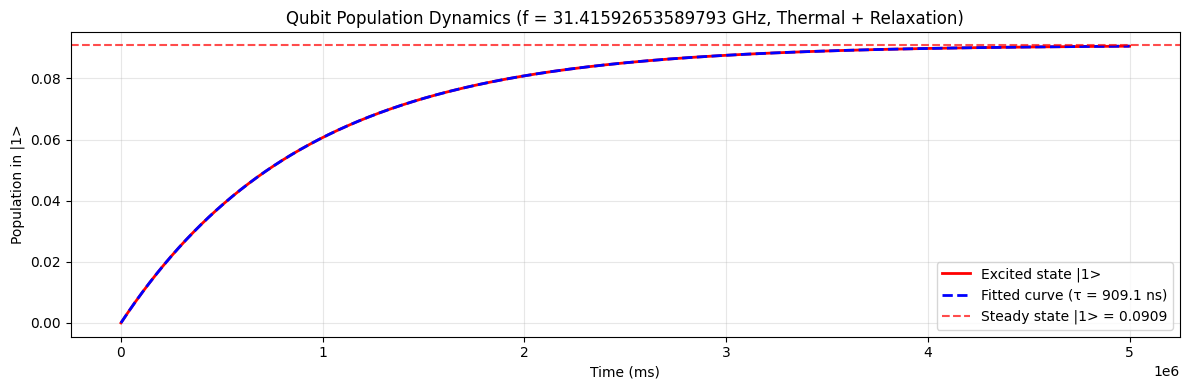


Qubit frequency: 31.41592653589793 GHz
Final population in |1> at t = 5000000.0 ms: 0.090538


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import qutip as qt

# Parameters
omega_q = 5*2*np.pi  # Qubit frequency: 5 GHz (keeping in GHz units)
gamma_rel = 1/1e3  # Relaxation rate
gamma_th = 1/1e4# Thermal rate
initial_state = 0  # Initial state (ground state)

# Time evolution
t_span = (0, 5000)  # 50 ms simulation time
times = np.linspace(0, 5000, 10000)

# Define Pauli operators and Hamiltonian
sigma_z = qt.sigmaz()
sigma_plus = qt.sigmam()
sigma_minus = qt.sigmap()

# Hamiltonian (free evolution)
H = omega_q*qt.sigmam()*qt.sigmap()

# Define collapse operators for thermal and relaxation processes
c_ops = []
# Relaxation (|1> -> |0>)
c_ops.append(np.sqrt(gamma_rel) * sigma_minus)
# Thermal excitation (|0> -> |1>)
c_ops.append(np.sqrt(gamma_th) * sigma_plus)

# Initial state
if initial_state == 0:
    psi0 = qt.basis(2, 0)  # Ground state |0>
else:
    psi0 = qt.basis(2, 1)  # Excited state |1>

# Solve using QuTiP's master equation solver
result = qt.mesolve(H, psi0, times, c_ops)
# Extract populations
p1 = np.real([state.ptrace(0)[1, 1] for state in result.states])
time = times
# Analytical steady state population
p1_steady = gamma_th / (gamma_th + gamma_rel)
print(f"Theoretical steady state population in |1>: {p1_steady:.6f}")

# Define exponential decay function for fitting
def exponential_approach(t, A, tau):
    return A * (1 - np.exp(-t / tau))

# Fit the data to exponential approach to steady state
try:
    # Initial guess for parameters
    p0 = [p1_steady, 1000]  # A, tau
    popt, pcov = curve_fit(exponential_approach, time, p1, p0=p0)
    A_fit, tau_fit = popt
    
    # Generate fitted curve
    p1_fit = exponential_approach(time, A_fit, tau_fit)
    
    print(f"Fitted parameters:")
    print(f"  Amplitude A: {A_fit:.6f}")
    print(f"  Time constant τ: {tau_fit:.1f} ns")
    
except Exception as e:
    print(f"Fitting failed: {e}")
    p1_fit = None

# Plot results
plt.figure(figsize=(12, 4))

plt.plot(time * 1000, p1, 'r-', label='Excited state |1>', linewidth=2)
if p1_fit is not None:
    plt.plot(time * 1000, p1_fit, 'b--', label=f'Fitted curve (τ = {tau_fit:.1f} ns)', linewidth=2)
plt.axhline(y=p1_steady, color='r', linestyle='--', alpha=0.7, 
           label=f'Steady state |1> = {p1_steady:.4f}')
plt.xlabel('Time (ms)')
plt.ylabel('Population in |1>')
plt.title(f'Qubit Population Dynamics (f = {omega_q} GHz, Thermal + Relaxation)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final populations
print(f"\nQubit frequency: {omega_q} GHz")
print(f"Final population in |1> at t = {time[-1]*1000:.1f} ms: {p1[-1]:.6f}")


In [15]:
psi0

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]]

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import qutip as qt

# Parameters (in rotating frame)
delta = 20e-3 * 2*np.pi  # Detuning: 20 MHz
omega_drive = 10e-3 * 2*np.pi  # Drive strength: 5 MHz
gamma_rel = 1/1e3  # Relaxation rate

# Time evolution
t_span = (0, 1000)  # 50 ms simulation time
times = np.linspace(0, 1000, 10000)

# Define Pauli operators
sigma_z = qt.sigmaz()
sigma_x = qt.sigmax()
sigma_plus = qt.sigmap()
sigma_minus = qt.sigmam()

# Hamiltonian in rotating frame (detuning + drive)
H = (delta/2) * sigma_z + (omega_drive/2) * sigma_x

# Define collapse operators for relaxation only
c_ops = []
# Relaxation (|1> -> |0>)
c_ops.append(np.sqrt(gamma_rel) * sigma_minus)

# Initial state: ground state of the rotating frame Hamiltonian
# Find ground state of H
eigenvals, eigenstates = H.groundstate()
psi0 = eigenstates  # Ground state of rotating frame Hamiltonian

In [231]:
psi0

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.22975292]
 [-0.97324899]]

In [232]:


# Solve using QuTiP's master equation solver
# We'll measure the first excited state population
# Get first excited state of H
eigenvals, eigenstates = H.eigenstates()
e_ops = [eigenstates[1] * eigenstates[1].dag()]  # First excited state of H projector
result = qt.mesolve(H, psi0, times, c_ops, e_ops)

/home/yunwei/.conda/envs/yunwei/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Fitted parameters:
Steady state population: 0.003091
Total rate (gamma_total): 0.000903
Relaxation rate (gamma_rel): 0.001000
Rate ratio (gamma_total/gamma_rel): 0.903


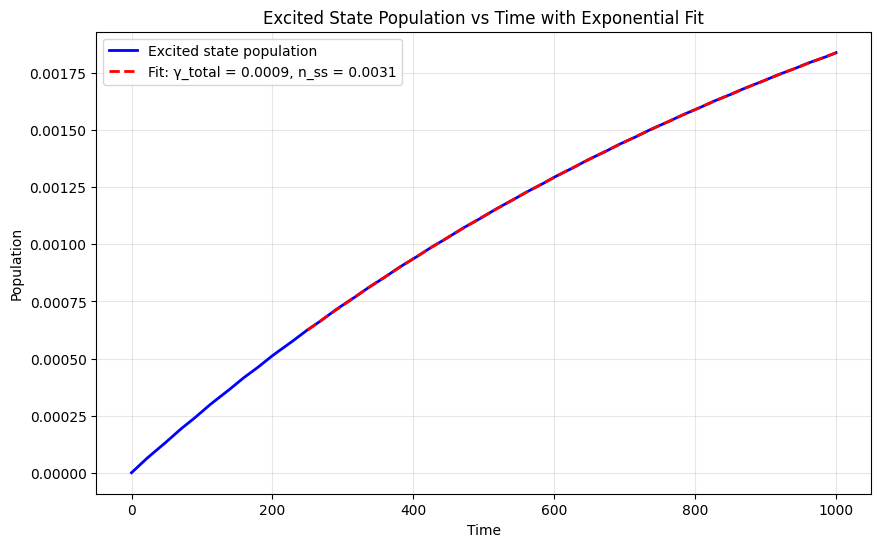

In [233]:
# Fit to exponential approach to steady state to extract total rate and population
def exponential_approach(t, A, gamma_total):
    """Exponential approach to steady state: A * (1 - exp(-gamma_total * t))"""
    return A * (1 - np.exp(-gamma_total * t))

# Get the data
population_data = result.expect[0]

# Fit the data (use later part of the time series for better convergence)
fit_start_idx = len(times) // 4  # Start fitting from 1/4 of the way through
t_fit = times[fit_start_idx:]
pop_fit = population_data[fit_start_idx:]

# Initial guess: steady state population and total rate
p0 = [pop_fit[-1], 2*gamma_rel]

# Perform the fit
popt, pcov = curve_fit(exponential_approach, t_fit, pop_fit, p0=p0)
steady_state_pop, gamma_total_fit = popt

print(f"Fitted parameters:")
print(f"Steady state population: {steady_state_pop:.6f}")
print(f"Total rate (gamma_total): {gamma_total_fit:.6f}")
print(f"Relaxation rate (gamma_rel): {gamma_rel:.6f}")
print(f"Rate ratio (gamma_total/gamma_rel): {gamma_total_fit/gamma_rel:.3f}")

# Plot the excited state population with fit
plt.figure(figsize=(10, 6))
plt.plot(times, population_data, 'b-', linewidth=2, label='Excited state population')
plt.plot(t_fit, exponential_approach(t_fit, *popt), 'r--', linewidth=2, 
         label=f'Fit: γ_total = {gamma_total_fit:.4f}, n_ss = {steady_state_pop:.4f}')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Excited State Population vs Time with Exponential Fit')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [249]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import qutip as qt
from system import sort_eigenpairs
# Parameters (in lab frame)
omega_q = 5 * 2*np.pi  # Qubit frequency: 5 GHz
omega_d = (5 + 20e-3) * 2*np.pi  # Drive frequency: 5.02 GHz
omega_drive = 10e-3 * 2*np.pi  # Drive strength: 10 MHz
gamma_rel = 1/1e3  # Relaxation rate

# Time evolution
t_span = (0, 500)  # 10 ms simulation time
times = np.linspace(0, 500, 1000)

# Define Pauli operators
sigma_z = qt.sigmaz()
sigma_x = qt.sigmax()
sigma_plus = qt.sigmap()
sigma_minus = qt.sigmam()

# Time-dependent Hamiltonian in lab frame
def H_lab(t, args):
    return (omega_q/2) * sigma_z + (omega_drive) * (np.cos(omega_d * t) * sigma_x)

# For Floquet analysis, we need the time-periodic Hamiltonian
T = 2*np.pi/omega_d  # Period of the drive

# Define collapse operators for relaxation only
c_ops = []
# Relaxation (|1> -> |0>)
c_ops.append(np.sqrt(gamma_rel) * sigma_minus)

floquet_basis = qt.FloquetBasis(H_lab, T, args={'w': omega_d})
# Compute Floquet modes and energies
f_modes = floquet_basis.mode(0)
f_energies = floquet_basis.e_quasi
f_modes = np.array(f_modes)
# Convert list of Qobj to numpy array
f_modes_array = []
for mode in f_modes:
    f_modes_array.append(mode.full().flatten())
f_modes = np.array(f_modes_array)
f_modes = f_modes.T
evals, U = sort_eigenpairs(f_energies,f_modes)
# Initial state: ground state of Floquet Hamiltonian
psi0 = qt.Qobj(f_modes[:,0])

In [250]:
# # Solve using QuTiP's Floquet master equation solver without e_ops first
# Solve using QuTiP's Floquet master equation solver without e_ops first
result = qt.mesolve(H_lab, psi0, times, c_ops, options=qt.Options(rtol=1e-12, atol=1e-12))

In [251]:
# Calculate Floquet state populations at each time point
floquet_populations = []
for i, t in enumerate(times):
    f_modes = floquet_basis.mode(t)
    f_energies = floquet_basis.e_quasi
    f_modes = np.array(f_modes)
    # Convert list of Qobj to numpy array
    f_modes_array = []
    for mode in f_modes:
        f_modes_array.append(mode.full().flatten())
    f_modes = np.array(f_modes_array)
    f_modes = f_modes.T
    evals, U = sort_eigenpairs(f_energies,f_modes)
    estate = qt.Qobj(U[:,0])
    P1 = estate*estate.dag()
    overlap = qt.expect(P1, result.states[i])
    floquet_populations.append(overlap)

floquet_populations = np.array(floquet_populations)

Fitted parameters:
A (steady state population): 0.003060
gamma_total (total rate): 0.000915


/tmp/ipykernel_1553612/2339528656.py:4: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(-gamma_total * t))


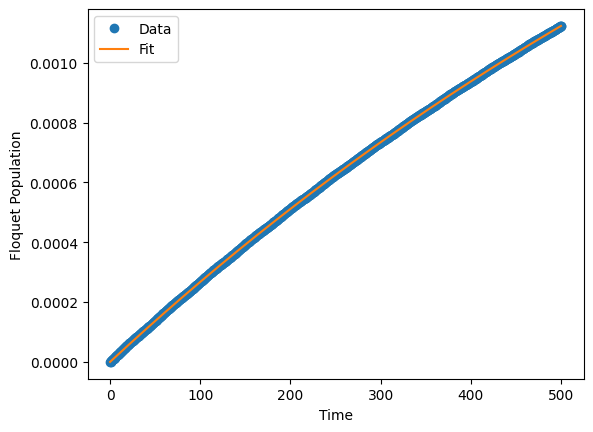

In [252]:
# Fit to exponential approach to steady state to extract total rate and population
def exponential_approach(t, A, gamma_total):
    """Exponential approach to steady state: A * (1 - exp(-gamma_total * t))"""
    return A * (1 - np.exp(-gamma_total * t))

# Fit the data
from scipy.optimize import curve_fit
popt, pcov = curve_fit(exponential_approach, times, floquet_populations)
A_fit, gamma_total_fit = popt

print(f"Fitted parameters:")
print(f"A (steady state population): {A_fit:.6f}")
print(f"gamma_total (total rate): {gamma_total_fit:.6f}")

# Plot the data and fit
plt.plot(times, floquet_populations, 'o', label='Data')
plt.plot(times, exponential_approach(times, A_fit, gamma_total_fit), '-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Floquet Population')
plt.legend()
plt.show()